# An analysis of excess deaths in Brazil during the COVID-19 pandemics

In this analysis we want to understand how excess data deaths can be used to see the impact of a major pandemic/epidemic in a population using the CRISP-DM process, for that we will try to awnser de following questions for the impact of the COVID pandemic in Brazil:

* How the number of excess deaths compare to the official number of deaths?
* What was the percentage increase (p-score) in deaths in the pandemic period?
* Which states had the biggest increase in deaths due to the pandemic?
* Which cities had the biggest increase in deaths due to the pandemic?

First lets load the data (scraped by capyvara from the Brasilian civil registry, https://github.com/capyvara/brazil-civil-registry-data):

In [1]:
from excess_deaths import excess_deaths, start_plot, end_plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

df = pd.read_csv("civil_registry_deaths.csv") # Downloaded 2021-03-05 23:08 UTC.

df.head()

,start_date,end_date,state,state_ibge_code,city,city_ibge_code,deaths_total,created_at
0,2015-01-01,2015-01-31,AC,12,NaN,NaN,249,2021-04-05 10:29
1,2015-02-01,2015-02-28,AC,12,NaN,NaN,209,2021-04-05 10:23
2,2015-03-01,2015-03-31,AC,12,NaN,NaN,255,2021-04-05 10:29
3,2015-04-01,2015-04-30,AC,12,NaN,NaN,216,2021-04-05 10:23
4,2015-05-01,2015-05-31,AC,12,NaN,NaN,244,2021-04-05 10:29


In [2]:
df.tail()

,start_date,end_date,state,state_ibge_code,city,city_ibge_code,deaths_total,created_at
291930,2020-11-01,2020-11-30,TO,17,Xambioá,1722107.0,9,2021-04-05 10:29
291931,2020-12-01,2020-12-31,TO,17,Xambioá,1722107.0,5,2021-04-05 10:23
291932,2021-01-01,2021-01-31,TO,17,Xambioá,1722107.0,7,2021-04-05 10:29
291933,2021-02-01,2021-02-28,TO,17,Xambioá,1722107.0,4,2021-04-05 10:23
291934,2021-03-01,2021-03-31,TO,17,Xambioá,1722107.0,5,2021-04-05 10:29


We have in our data the number of deaths by month for each city in the country and again in an agreggation for each state (rows with city and city_ibge_code null).

The `excess_deaths` filter the data using a boolean mask and split it in two parts, the first is all data before `start_date`, this data will be used to calculate a mean number of deaths for each month of the year, the second data is the number of deaths between `start_date` and `end_date`, and will be used to calculate the excess deaths.

Let's first take a look at the data by looking at the mean number of deaths before `start_date` and total number of deaths between `start_date` and `end_date` for the whole country.

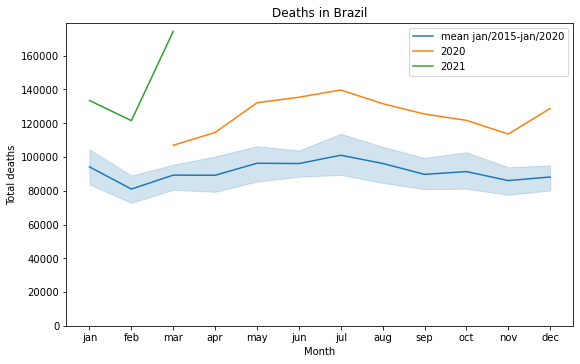

In [3]:
start_date = datetime.date(2020, 3, 1)
end_date = datetime.date(2021, 3, 31)

# Only rows with null city will be selected to avoid repeated data,
# this coud be also done by selecting only rows with not null city
# but this can take way longer to run.
br_ed = excess_deaths(df, mask=df.city.isnull(), start_date=start_date, end_date=end_date)
br_ed.plot_deaths(title="Deaths in Brazil", zero_y=True)

## How the number of excess deaths compare to the official number of deaths?

Now let's take a look at the total number of excess deaths in the considered period:

In [4]:
br_deaths_lower, br_deaths_higher, _ = br_ed.count_excess_deaths()
print("Deaths above the mean: {}".format(int(br_deaths_higher)))
print("Deaths above the mean plus standard deviation: {}".format(int(br_deaths_lower)))

Deaths above the mean: 491586
Deaths above the mean plus standard deviation: 332501


This number is 53% bigger than the number of con

And to compare let's load the Our World on Data dataset to compare the cumulative number of excess deaths to the confirmed number of deaths.


In [5]:
covid_df = pd.read_csv("owid-covid-data.csv")

# Select only valid total_deaths data from Brazil, 
# null values in the new_deaths column are from before 
# the first death and before the considerated period 
# so they will be removed.
br_covid_df = covid_df[(covid_df.location == "Brazil") & covid_df.new_deaths.notnull()]
total_conf_deaths = br_covid_df[br_covid_df.date == end_date.strftime("%Y-%m-%d")].iloc[0].total_deaths
print("Confirmed COVID deaths: {}".format(int(total_conf_deaths)))
print("Percentage diference: {:.1f}%".format(100*(br_deaths_higher-total_conf_deaths)/total_conf_deaths))


Confirmed COVID deaths: 321515
Percentage diference: 52.9%


The number of excess deaths is 52.9% higher than the number of confirmed cases.

We can also see the difference by month:

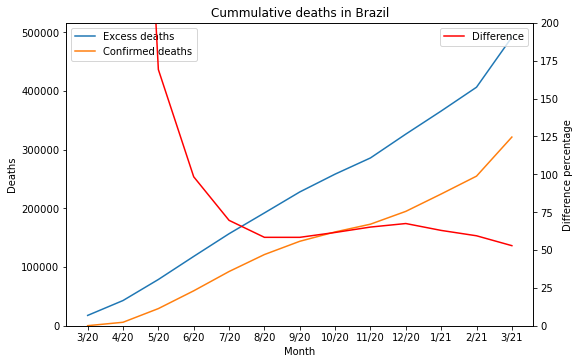

In [6]:
br_ed.plot_excess_deaths_comparison(br_covid_df, "date", "new_deaths", "Confirmed deaths", zero_y=True, ylim=(0, 200), title="Cummulative deaths in Brazil")


We see a huge difference in the first half of 2020, indicating that even before tha pandemic started the year already was experiencing a higher than normal number of deaths. But in the second hal of the year the difference stabilizes in arround 60%, in the beginning of 2021 the difference starts a decreacing trend, probably to to imcompleteness in the data or better diagnostics statitiscs.

## What was the percentage increase (p-score) in deaths in the pandemic period?

We can now plot the p-score, p-score is the percentage increase from the mean number of deaths and is directly connected to excess deaths.

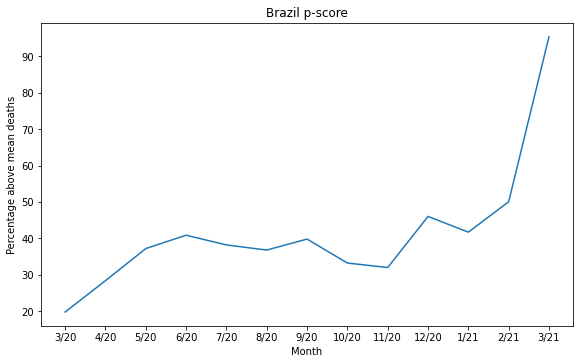

In [7]:
br_ed.plot_p_score(title="Brazil p-score")

We can see a p-score of around 40% during 2020 after the first increase, reflecting an stable number of new cases observed in the second half of the year, but starting February/2021 we see a huge spike in the p-score, passing 90% in march, this probably is a reflection of the large growth in new cases after the holidays associated with the collapse of the health system in many cities of the country in the month of march.


## Which states had the biggest increase in deaths due to the pandemic?

We can instance an excess_death object for each state and calculate the excess deaths an p-score for each one.

In [8]:
def gen_results_df(df, masks, restriction=lambda *_: False):
    """ Instances an excess_deaths object for each pased mask, calculates excess deaths
        and p-scores and stores everything in a DataFrame.
    
    Args:
        df (DataFrame): DataFrame to load data.
        masks (dict): Dictionary of the masks to be used.
        restriction (function, optional): A function that accepts the excess
            deaths number, the mean number of deaths and the p-score and
            returns a True if that value is to be disconsidered due to a restriction.

    Returns:
        DataFrame: Excess deaths, p-scores and excess_deaths object for each mask.
    """
    from tqdm import tqdm
    results_df = pd.DataFrame(columns=["name", "excess_deaths", "p-score", "ed_object"])
    errors_list = []

    for name, mask in tqdm(masks.items()):
        # Instances a excess_deaths object for the given mask
        try:
            ed_object = excess_deaths(df, mask=mask, start_date=start_date, end_date=end_date)
        except RuntimeError:
            errors_list.append((name, "Not enough data."))
            continue
        # Calculate the excess deaths and p-score for the entire period
        lower_ex, higher_ex, mean = ed_object.count_excess_deaths()
        p_score = 100*(higher_ex)/mean
        # Stores excess_deaths object and p-score 
        if not restriction(higher_ex, mean, p_score):
            results_df = results_df.append({
                "name": name, 
                "excess_deaths": higher_ex, 
                "p-score": p_score, 
                "ed_object": ed_object
            }, ignore_index=True)
        else:
            errors_list.append((name, "Restriction not met."))
            continue
    
    # Check if there where errors
    if len(errors_list) == 0:
        print("\nNo error caculationg given masks.")
    else:
        print("\n{} masks where not processed due to errors.".format(len(errors_list)))
    
    return results_df


# Genarates a mask for each state, again we will use only the rows with
# null city to avoid loading duplicated data.
state_masks = {state: df.city.isnull() & (df.state == state) for state in df.state.unique()}
states_results_df = gen_results_df(df, state_masks)

100%|██████████| 27/27 [00:00<00:00, 33.38it/s]
No error caculationg given masks.



We can see the states with the highest p-score:

In [9]:
states_results_df.sort_values(by="p-score", ascending=False).head()

,name,excess_deaths,p-score,ed_object
2,AM,18709.200000,236.711455,<excess_deaths.excess_deaths object at 0x7fdb3...
9,MA,20388.033333,166.067351,<excess_deaths.excess_deaths object at 0x7fdb3...
13,PA,21635.600000,129.566905,<excess_deaths.excess_deaths object at 0x7fdb3...
18,RJ,89240.100000,86.488134,<excess_deaths.excess_deaths object at 0x7fdb3...
5,CE,28095.333333,79.366096,<excess_deaths.excess_deaths object at 0x7fdb3...


And with the biggest absolute number of excess deaths:

In [10]:
states_results_df.sort_values(by="excess_deaths", ascending=False).head()

,name,excess_deaths,p-score,ed_object
18,RJ,89240.100000,86.488134,<excess_deaths.excess_deaths object at 0x7fdb3...
25,SP,87931.133333,26.912322,<excess_deaths.excess_deaths object at 0x7fdb3...
4,BA,31892.233333,44.664012,<excess_deaths.excess_deaths object at 0x7fdb3...
22,RS,31273.366667,38.364399,<excess_deaths.excess_deaths object at 0x7fdb3...
10,MG,30541.100000,21.582764,<excess_deaths.excess_deaths object at 0x7fdb3...


We can also graphically see the states with the biggest p-scores and biggest absolute number of excess deaths:

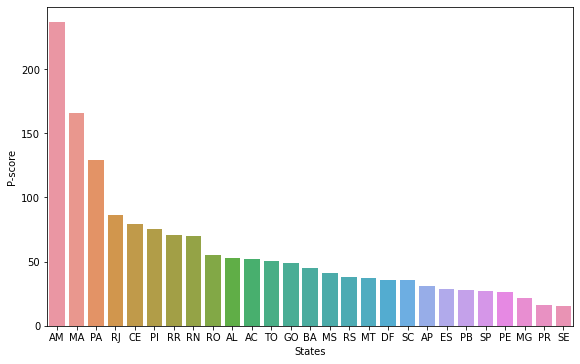

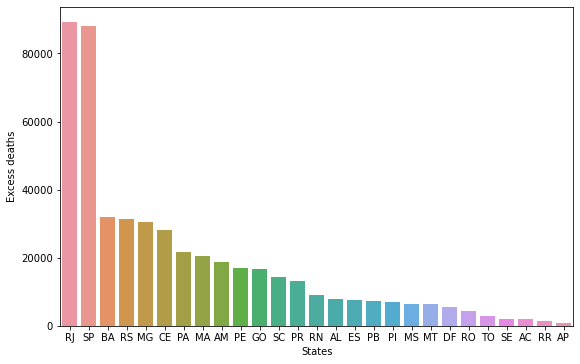

In [11]:
def biggest_barplot(df, y, xlabel, ylabel, n=None):
    """ Plot a barplot of a column of a DataFrame in decreasing order.

    Args:
        df (DataFrame): DataFrame with data to plot.
        y (str): Column with data to plot.
        xlabel (str): Label for the x axis.
        ylabel (str): Label for the y axis.
        n (int):  Number of rows to plot.
    """
    # Sort dataframe
    df = df.sort_values(by=y, ascending=False)
    if n is not None:
        df = df.head(n=n)
    #plot data
    start_plot()
    sns.barplot(x="name", y=y, data=df.sort_values(by=y, ascending=False))
    end_plot(xlabel=xlabel, ylabel=ylabel)

biggest_barplot(states_results_df, "p-score", xlabel="States", ylabel="P-score")
biggest_barplot(states_results_df, "excess_deaths", xlabel="States", ylabel="Excess deaths")

## Which cities had the biggest increase in deaths due to the pandemic?

We will exclude cities that does not have:

* At leat 12 months of previous data to use as a mean;
* The data detween `start_date` and `end_date`;
* A cumulative mean deaths to use to compare in the interval `start_date` and `end_date` of at least 100.



In [12]:
# Generates masks for all cities in data
cities_masks = {}
for city_code in df[df.city_ibge_code.notnull()].city_ibge_code.unique():
    mask = df.city_ibge_code == city_code
    city = "{}-{}".format(df[mask].city.iloc[0], df[mask].state.iloc[0])
    cities_masks[city] = mask

# Will only consider cities with a mean number of deaths for the period above 100
def cities_restictions(excess_deaths, mean_deaths, p_score):
    return mean_deaths <= 100

cities_results_df = gen_results_df(df, cities_masks, cities_restictions)

100%|██████████| 5004/5004 [02:03<00:00, 40.38it/s]
3413 masks where not processed due to errors.



A large number of cities did not met your selection criterea, for this analysis this will sulfice because all major cities sould be able to meet the criterea, but for more detailed analysis a closer look in the small cities might be nescessary.

Lets order the data using the p-score and see the results of the 10 cities with the biggest p-score.

In [13]:
cities_results_df.sort_values(by="p-score", ascending=False).head(10)

,name,excess_deaths,p-score,ed_object
355,Caxias-MA,788.250000,268.340426,<excess_deaths.excess_deaths object at 0x7fdb2...
37,Manaus-AM,14963.866667,221.125637,<excess_deaths.excess_deaths object at 0x7fdb2...
665,Benevides-PA,264.500000,217.695473,<excess_deaths.excess_deaths object at 0x7fdb2...
258,Viçosa do Ceará-CE,268.333333,205.357143,<excess_deaths.excess_deaths object at 0x7fdb2...
34,Itacoatiara-AM,369.200000,205.339266,<excess_deaths.excess_deaths object at 0x7fdb2...
203,Brejo Santo-CE,245.916667,190.510006,<excess_deaths.excess_deaths object at 0x7fdb2...
1582,Colinas do Tocantins-TO,200.083333,185.405405,<excess_deaths.excess_deaths object at 0x7fdb1...
993,Maricá-RJ,1237.000000,185.179641,<excess_deaths.excess_deaths object at 0x7fdb2...
198,Acopiara-CE,190.166667,181.399046,<excess_deaths.excess_deaths object at 0x7fdb2...
966,Arraial do Cabo-RJ,210.083333,179.686386,<excess_deaths.excess_deaths object at 0x7fdb2...


Let's also see the 10 cities with the biggest number of absolute excess deaths:

In [14]:
cities_results_df.sort_values(by="excess_deaths", ascending=False).head(10)

,name,excess_deaths,p-score,ed_object
1017,Rio de Janeiro-RJ,38024.333333,85.320120,<excess_deaths.excess_deaths object at 0x7fdb2...
1548,São Paulo-SP,24237.000000,25.764582,<excess_deaths.excess_deaths object at 0x7fdb1...
37,Manaus-AM,14963.866667,221.125637,<excess_deaths.excess_deaths object at 0x7fdb2...
1152,Porto Alegre-RS,10007.400000,72.200338,<excess_deaths.excess_deaths object at 0x7fdb2...
213,Fortaleza-CE,9303.333333,52.146781,<excess_deaths.excess_deaths object at 0x7fdb2...
159,Salvador-BA,7429.833333,42.780918,<excess_deaths.excess_deaths object at 0x7fdb2...
664,Belém-PA,6720.033333,119.915655,<excess_deaths.excess_deaths object at 0x7fdb2...
260,Brasília-DF,5631.333333,35.889701,<excess_deaths.excess_deaths object at 0x7fdb2...
1024,São Gonçalo-RJ,5131.233333,116.255202,<excess_deaths.excess_deaths object at 0x7fdb2...
1002,Nova Iguaçu-RJ,4945.733333,144.179267,<excess_deaths.excess_deaths object at 0x7fdb2...


Manaus-AM is the capial of Amazonas, and it appear in the 10 biggest p-scores and the biggest absolute excess deaths, so let's take a closer look at it:

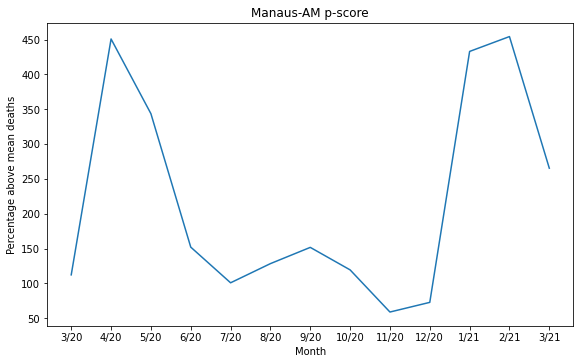

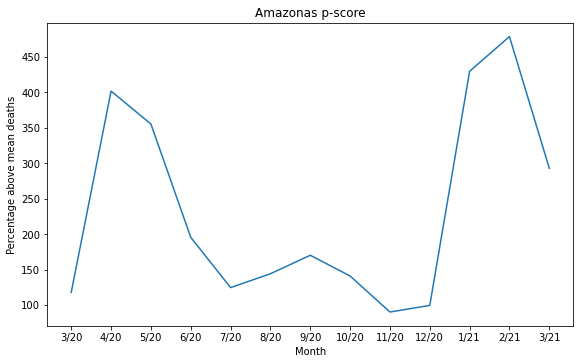

In [15]:
manaus_ed = cities_results_df[cities_results_df.name == "Manaus-AM"].iloc[0]["ed_object"]
manaus_ed.plot_p_score(title="Manaus-AM p-score")

am_ed = states_results_df[states_results_df.name == "AM"].iloc[0]["ed_object"]
am_ed.plot_p_score(title="Amazonas p-score")

As we can see Manaus had two large peaks, provoking, in most part, the two large peaks for the state of Amazonas. In those two moments the health system of the state entered a state of collapse, with no ICU beds available and, in the second peak, a shortage of oxygen for patients.

## Conclusions

We managed to observe a correlation between the excess deaths, this is an indication that the excess deaths might really be a good measure of the real impact of the pandemic, the proportion observed of the two values is also inside the expected.

The major events during the pandemic were also observed in the excess deaths data.

In places where there is a publicly available registry of deaths excess deaths can easily be calculated and provides a good indicator of the progress of a major disease in the population.